# Testing Navier-Stokes with a body in package `ViscousFlow`

In [9]:
using ViscousFlow

┌ Info: Precompiling ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1242


In [11]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [104]:
Re = 500; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body. Here is a plate:

In [13]:
n = 51;
body = Bodies.Plate(1.0,n)

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


or here is an airfoil

In [32]:
n = 60;
body = Bodies.NACA4(0.0,0.0,0.12,np=n)

NACA 4-digit airfoil with 119 points and length 1.0 and thickness 0.12
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


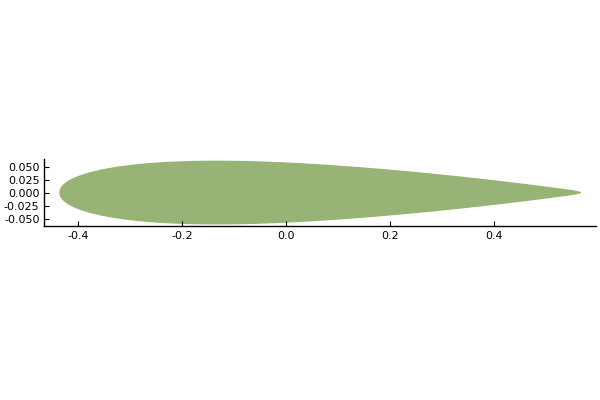

In [19]:
plot(body)

Transform the body with a specified initial position and orientation.

In [105]:
cent = (0.0,0.0) #1.0+1.0im
α = -5π/180 #-π/3 #-π/4
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

NACA 4-digit airfoil with 119 points and length 1.0 and thickness 0.12
   Current position: (0.0,0.0)
   Current angle (rad): -0.08726646259971647


Set up the domain

In [106]:
xlim = (-1.0,3.0)
ylim = (-1.0,1.0)

(-1.0, 1.0)

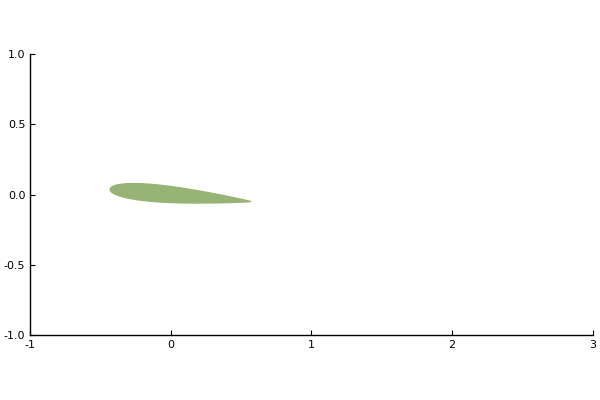

In [107]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [108]:
X = VectorData(body.x,body.y);

Set the domain size and time step size

In [109]:
Δx = 0.01;
Δt = min(0.5*Δx,0.5*Δx^2*Re);

### Now set up the system

Set up the state vector and constraint force vector for a static body

In [110]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 416 x 208

In [111]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(X);
xg, yg = coordinates(w₀,dx=Δx,I0=Systems.origin(sys))

(-1.075:0.01:3.075, -1.035:0.01:1.035)

Set up the integrator here

In [112]:
plan_intfact(t,u) = Systems.plan_intfact(t,u,sys)
plan_constraints(u,t) = TimeMarching.plan_constraints(u,t,sys)
r₁(u,t) = TimeMarching.r₁(u,t,sys)
r₂(u,t) = TimeMarching.r₂(u,t,sys)


@time ifherk = IFHERK(w₀,f,sys.Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=TimeMarching.RK31,isstored=true)

  5.473880 seconds (1.81 M allocations: 2.415 GiB, 6.12% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,416,208}
   Force of type VectorData{119}
   Time step size 0.005


Initialize the state vector and the history vectors

In [113]:
t = 0.0
w₀ .= 0.0
u = deepcopy(w₀)

fx = Float64[];
fy = Float64[];
thist = Float64[];

uhist = [];
tsample = 0.2; # rate at which to store field data

### Advance the system!

Set the time range to integrate over.

In [114]:
tf = 3.0;
T = Δt:Δt:tf;

In [115]:
for ti in T
    global t, u, f = ifherk(t,u)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-6) || isapprox(mod(t,tsample),tsample,atol=1e-6)) ? push!(uhist,deepcopy(u)) : nothing
end
println("solution completed through time t = ",t)

solution completed through time t = 2.9999999999999583


#### Plotting

Basic plot

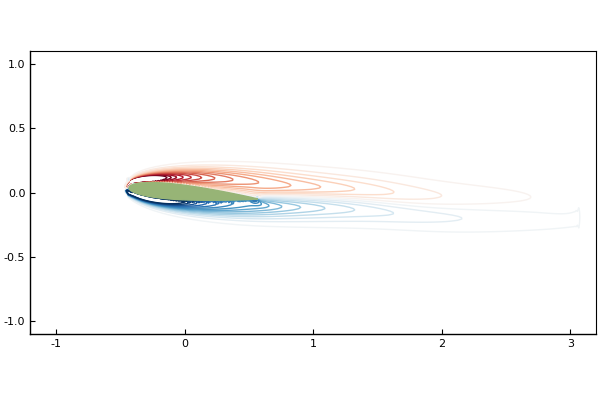

In [116]:
plot(xg,yg,vorticity(uhist[end],sys),levels=range(-15,15,length=30), color = :RdBu,clim=(-15,15))
plot!(body)

Streamlines

In [117]:
ψ = zero(uhist[1])
ψ .= streamfunction(uhist[end],sys) .+ sys.U∞[1]*yg';

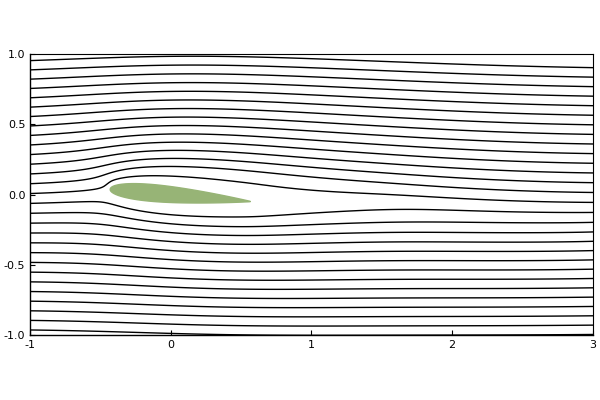

In [118]:
plot(xg,yg,ψ,levels=range(-1,1,length=31), color = :black,clim=(-0.25,0.25),xlim=(-1,3),ylim=(-1,1))
plot!(body)

Plot lift and drag coefficient

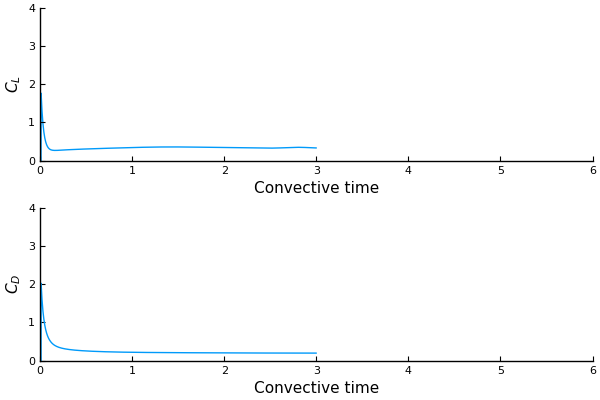

In [119]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],thist,2*fy,xlim=(0,6),ylim=(0,4),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],thist,2*fx,xlim=(0,6),ylim=(0,4),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt